# Spectral Abundance Mapping

In [1]:
import hylite
from hylite import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# load the image using hylite
hymap=io.load('/Users/rachdi18/Documents/Namibia_Epembe/final_subsets/final/hymap_final_sub.hdr')
enmap = io.load( '/Users/rachdi18/Documents/Namibia_Epembe/final_subsets/final/enmap_final_sub.hdr' )
Prisma=io.load('/Users/rachdi18/Documents/Namibia_Epembe/final_subsets/final/prisma_final_sub.hdr')
EMIT=io.load('/Users/rachdi18/Documents/Namibia_Epembe/final_subsets/final/emit_final_sub.hdr')
image = EMIT

In [4]:
image.decompress()
image.set_as_nan(0)
image.data = image.data.astype(np.float32)
image.data[ image.data <= 0. ] = np.nan

In [5]:
# Getting the wavelength array
image.get_wavelengths()

array([ 381.00558,  388.4092 ,  395.81583,  403.2254 ,  410.638  ,
        418.0536 ,  425.47214,  432.8927 ,  440.31726,  447.7428 ,
        455.17035,  462.59888,  470.0304 ,  477.46292,  484.89743,
        492.33292,  499.77142,  507.2099 ,  514.6504 ,  522.0909 ,
        529.5333 ,  536.9768 ,  544.42126,  551.8667 ,  559.3142 ,
        566.7616 ,  574.20905,  581.6585 ,  589.108  ,  596.55835,
        604.0098 ,  611.4622 ,  618.9146 ,  626.36804,  633.8215 ,
        641.2759 ,  648.7303 ,  656.1857 ,  663.6411 ,  671.09753,
        678.5539 ,  686.0103 ,  693.4677 ,  700.9251 ,  708.38354,
        715.84094,  723.2993 ,  730.7587 ,  738.2171 ,  745.6765 ,
        753.1359 ,  760.5963 ,  768.0557 ,  775.5161 ,  782.97754,
        790.4379 ,  797.89935,  805.36176,  812.8232 ,  820.2846 ,
        827.746  ,  835.2074 ,  842.66986,  850.1313 ,  857.5937 ,
        865.0551 ,  872.5176 ,  879.98004,  887.44147,  894.90393,
        902.3664 ,  909.82886,  917.2913 ,  924.7538 ,  932.21

By splitting the spectral analysis into VNIR and SWIR subsets, we can focus on the specific diagnostic features present in each region. This allows for more accurate and detailed mineral identification and mapping. 

In [6]:
#subset the VNIR range ±500 nm to ±1000 nm
#subset the SWIR range ±2000 nm to ±2400 nm
wav_emit_ep = np.array([
      2004.35498 , 2011.774536,
       2019.193115, 2026.611816, 2034.030396, 2041.447144, 2048.86499 ,
       2056.280762, 2063.696533, 2071.112305, 2078.527344, 2085.942139,
       2093.356201, 2100.769043, 2108.182129, 2115.594238, 2123.006348,
       2130.41748 , 2137.828857, 2145.239014, 2152.648193, 2160.057617,
       2167.467041, 2174.875488, 2182.282959, 2189.69043 , 2197.096924,
       2204.503418, 2211.90918 , 2219.314697, 2226.719482, 2234.123291,
       2241.526855, 2248.929688, 2256.332764, 2263.734619, 2271.136475,
       2278.537598, 2285.938721, 2293.338623, 2300.737793, 2308.135986,
       2315.53418 , 2322.932617, 2330.329834, 2337.726318, 2345.121582,
       2352.51709 , 2359.912598, 2367.307129, 2374.700684, 2382.093506,
       2389.486084, 2396.87793 ,2400])

image_subset = image.export_bands(wav_emit_ep)

(<Figure size 1800x600 with 1 Axes>, <Axes: xlabel='Wavelength (nm)'>)

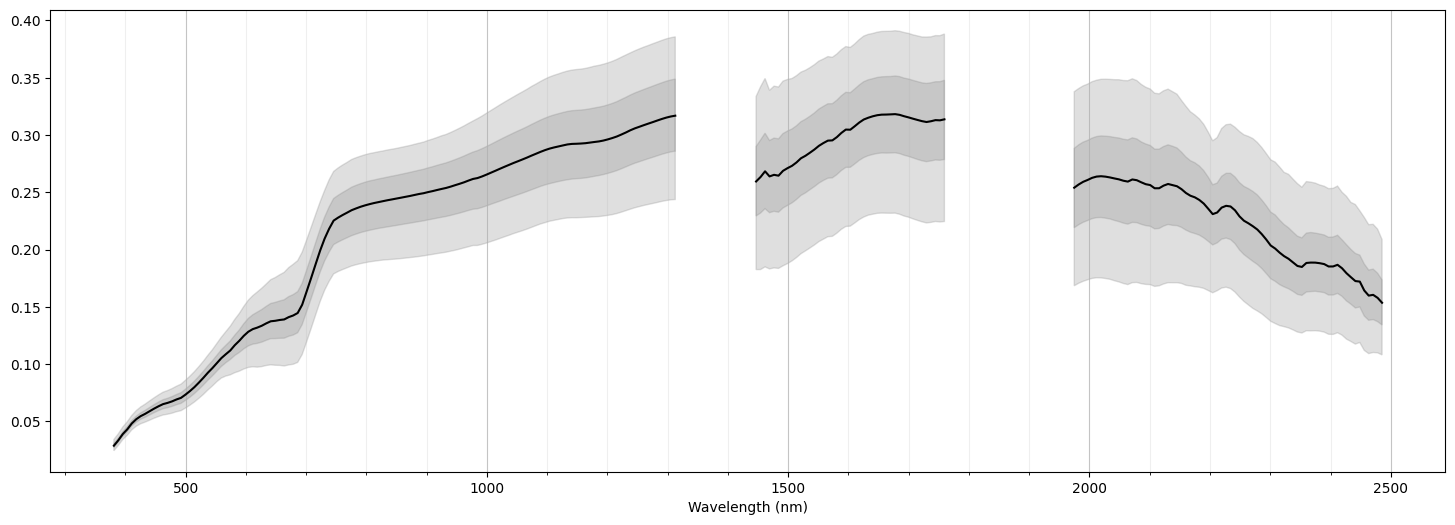

In [7]:
image.plot_spectra()

In [8]:
image_subset.delete_nan_bands()

In [9]:
#Run the N-finder analysis to extract endmembers
from pysptools.eea import NFINDR
em = NFINDR()
# we need to specify the number of endmembers
end_members = em.extract(image_subset.X(onlyFinite=True)[:,None,:], 5)

In [10]:
#Row and Column based locations of the endmembers
idxx = []
for em in end_members:
  idxx.append( np.argwhere( (image_subset.data.astype(np.float32) == em.astype(np.float32) ).all(axis=-1) )[0] )
idxx = np.array(idxx)

idxx

array([[199, 151],
       [247,   7],
       [170, 133],
       [184,   3],
       [  0,  87]])

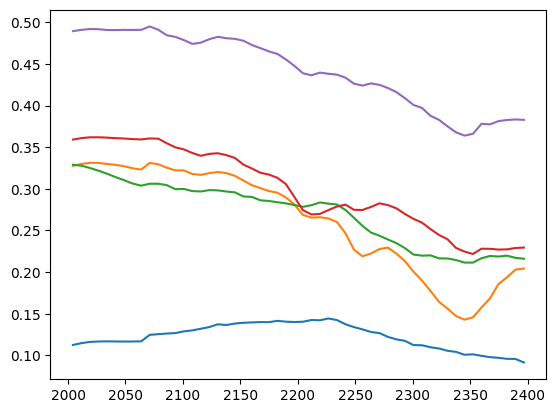

In [11]:
#plot all the endmembers
for em in end_members:
  plt.plot(image_subset.get_wavelengths(), em)

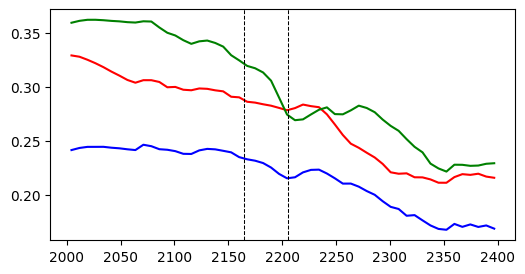

In [12]:
#spectral analysis of the enmembers
plt.figure(figsize=(6,3))
plt.plot( image_subset.get_wavelengths(), image_subset.data[170, 133,:], color = 'r' )
plt.plot( image_subset.get_wavelengths(), image_subset.data[ 184,   3,:], color= 'g' )
plt.plot( image_subset.get_wavelengths(), image_subset.data[199, 15,:], color= 'b' )
plt.axvline(x = 2205., color = 'k', linewidth=0.75, linestyle = '--', label = 'axvline - full height')
plt.axvline(x = 2165., color = 'k', linewidth=0.75, linestyle = '--', label = 'axvline - full height')

In [13]:
import pysptools.abundance_maps as amp
# Non-negative LS:
nnls_emit_ep = amp.NNLS()
# Find abundances:
unmixing = nnls_emit_ep.map(image_subset.X(onlyFinite=True)[:,None,:], end_members).squeeze()
amap_emit_ep = image_subset.copy()
amap_emit_ep.set_raveled(unmixing, onlyFinite=True, strict=False)
amap_emit_ep.set_projection_EPSG( image_subset.get_projection_EPSG())
amap_emit_ep.affine = image_subset.affine

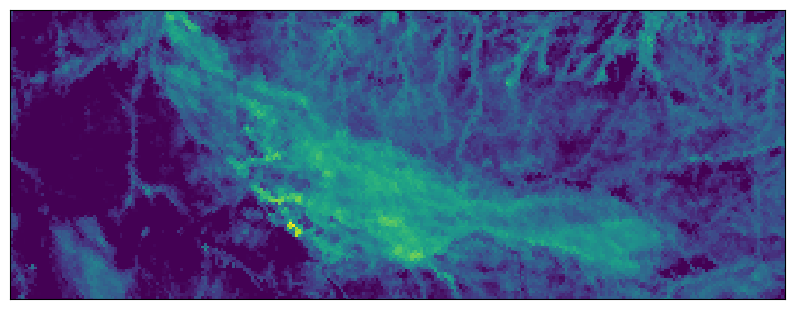

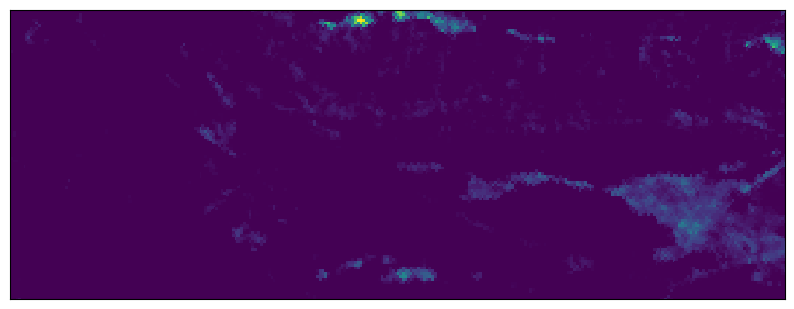

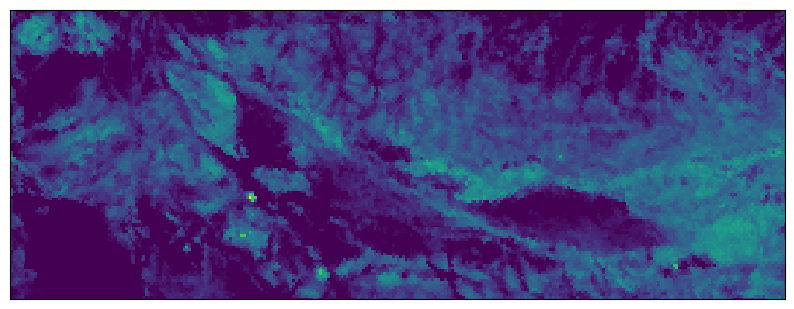

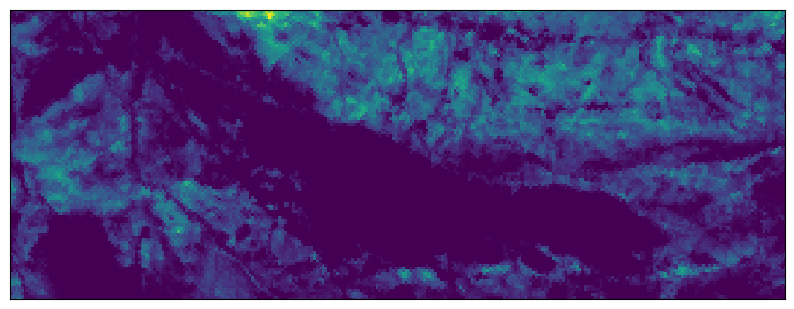

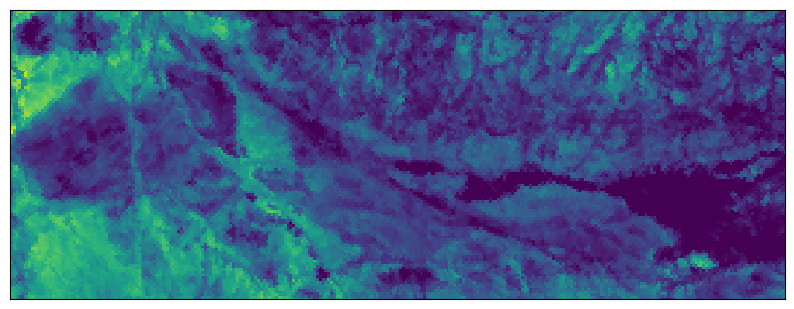

In [14]:
#print all the abundance maps (number of abundance maps will be equal to the endmembers)
for i in range(amap_emit_ep.band_count()):
  amap_emit_ep.quick_plot(i, vmin=0., vmax=1., figsize= (10,5))

After successfully extracting the mineral endmembers from our dataset, the next step involves generating abundance maps for these minerals using a similar computational process. To calculate the optimal composite representation of these maps, we introduce another spectral subset. In this subset, we concatenate the Visible and Near-Infrared (VNIR) range with the Short-Wave Infrared (SWIR) range.

In [15]:
wav_emit_ep = np.array([
        507.2099 ,  514.6504 ,  522.0909 ,
        529.5333 ,  536.9768 ,  544.42126,  551.8667 ,  559.3142 ,
        566.7616 ,  574.20905,  581.6585 ,  589.108  ,  596.55835,
        604.0098 ,  611.4622 ,  618.9146 ,  626.36804,  633.8215 ,
        641.2759 ,  648.7303 ,  656.1857 ,  663.6411 ,  671.09753,
        678.5539 ,  686.0103 ,  693.4677 ,  700.9251 ,  708.38354,
        715.84094,  723.2993 ,  730.7587 ,  738.2171 ,  745.6765 ,
        753.1359 ,  760.5963 ,  768.0557 ,  775.5161 ,  782.97754,
        790.4379 ,  797.89935,  805.36176,  812.8232 ,  820.2846 ,
        827.746  ,  835.2074 ,  842.66986,  850.1313 ,  857.5937 ,
        865.0551 ,  872.5176 ,  879.98004,  887.44147,  894.90393,
        902.3664 ,  909.82886,  917.2913 ,  924.7538 ,  932.21625,
        939.6788 ,  947.14026,  954.6027 ,  962.0643 ,  969.5268 ,
        976.9883 ,  984.4498 ,  991.9114 ,  999.37286,
       2004.35498 , 2011.774536,
       2019.193115, 2026.611816, 2034.030396, 2041.447144, 2048.86499 ,
       2056.280762, 2063.696533, 2071.112305, 2078.527344, 2085.942139,
       2093.356201, 2100.769043, 2108.182129, 2115.594238, 2123.006348,
       2130.41748 , 2137.828857, 2145.239014, 2152.648193, 2160.057617,
       2167.467041, 2174.875488, 2182.282959, 2189.69043 , 2197.096924,
       2204.503418, 2211.90918 , 2219.314697, 2226.719482, 2234.123291,
       2241.526855, 2248.929688, 2256.332764, 2263.734619, 2271.136475,
       2278.537598, 2285.938721, 2293.338623, 2300.737793, 2308.135986,
       2315.53418 , 2322.932617, 2330.329834, 2337.726318, 2345.121582,
       2352.51709 , 2359.912598, 2367.307129, 2374.700684, 2382.093506,
       2389.486084, 2396.87793 ,2400])

image_subset = image.export_bands(wav_emit_ep)

(3, 121)


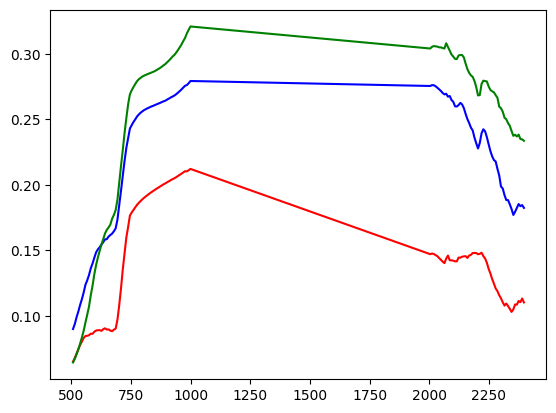

In [16]:
calcite = [200, 75]
kaolinite = [504,122]
hematite = [77, 196] 

calcite_spectra = image_subset.data[calcite[0], calcite[1], : ]
kaolinite_spectra = image_subset.data[kaolinite[0], kaolinite[1], : ]
hematite_spectra = image_subset.data[hematite[0], hematite[1], : ]

plt.plot(image_subset.get_wavelengths(), calcite_spectra, color= 'r')
plt.plot(image_subset.get_wavelengths(), kaolinite_spectra, color= 'b')
plt.plot(image_subset.get_wavelengths(), hematite_spectra, color= 'g')


endmembers_idx = np.vstack( [calcite_spectra, kaolinite_spectra, hematite_spectra] )
print(endmembers_idx.shape)

In [17]:
import pysptools.abundance_maps as amp
# Non-negative LS:
nnls_enmap_ep = amp.NNLS()
# Find abundances:
unmixing = nnls_enmap_ep.map(image_subset.X(onlyFinite=True)[:,None,:], endmembers_idx).squeeze()
amap_enmap_ep = image_subset.copy()
amap_enmap_ep.set_raveled(unmixing, onlyFinite=True, strict=False)
amap_enmap_ep.set_projection_EPSG( image_subset.get_projection_EPSG())
amap_enmap_ep.affine = image_subset.affine

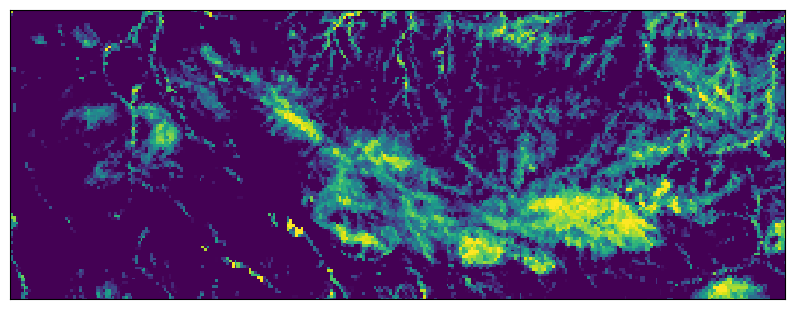

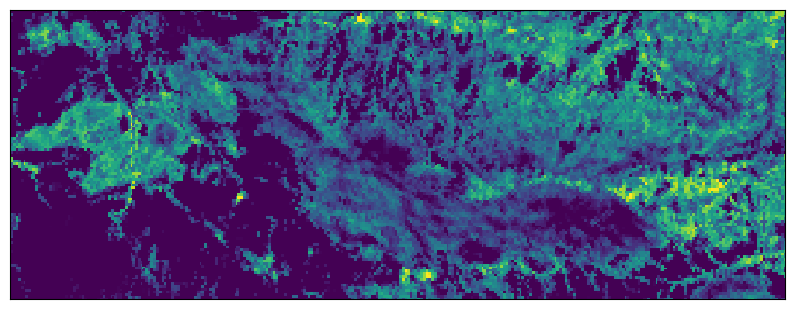

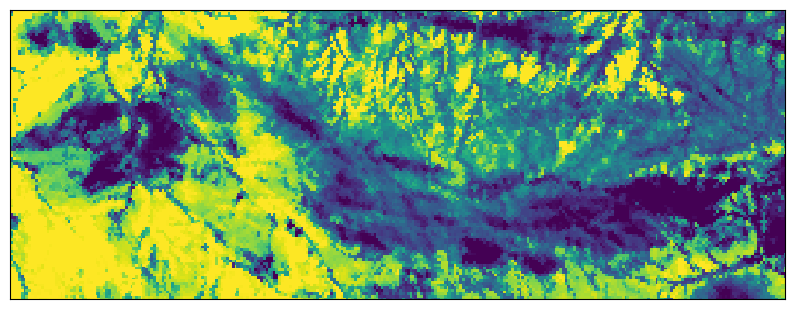

In [18]:
#print all the abundance maps (number of abundance maps will be equal to the endmembers)
for i in range(amap_enmap_ep.band_count()):
    amap_enmap_ep.quick_plot(i, vmin=0., vmax=1., figsize= (10,5))

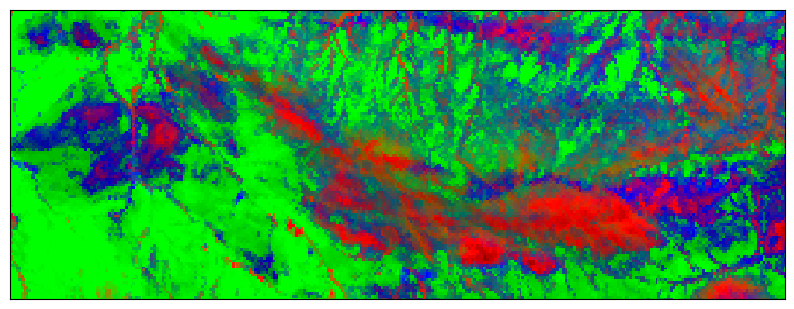

In [19]:
#compute the ideal composite
amap_enmap_ep.quick_plot((0,2,1), figsize= (10,7), ticks= False, vmin=0., vmax=1.)
amap_enmap_ep.set_projection_EPSG( image.get_projection_EPSG())
amap_enmap_ep.affine = image.affine

In [20]:
io.save('/Users/rachdi18/Documents/Namibia_Epembe/Results/AM/emit_AM', amap_enmap_ep)